# Good Afternoon Bluesky: REALLY starting your experiment

In this notebook you will:

* Prepare to collect data for analysis
* Assemble complex plans for single line exectution
* Create and test an "overnight" script
* Experience some guided troubleshooting for common errors


Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)
* [Good Morning Bluesky](./Good%20Morning%20Bluesky.ipynb)

In [ ]:
#pip install -U --pre databroker[all]

# Start Josh

## For Bluesky Session Continuity
Run the next cells to make the ipython kernel match the previous session


In [1]:
pip install -e gm_user

Obtaining file:///nsls2/users/abarbour/Repos/tutorials/gm_user
  Preparing metadata (setup.py) ... done
  Attempting uninstall: user-profile
    Found existing installation: user-profile 0.0.0
    Uninstalling user-profile-0.0.0:
      Successfully uninstalled user-profile-0.0.0
  Running setup.py develop for user-profile
Note: you may need to restart the kernel to use updated packages.


In [2]:
%run -i gm_user/user_profile.py

OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)


In [3]:
from gm_user import user_profile

OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)


In [4]:
%run -i gm_user/user_startup.py  user_startup_afternoon.py

In [5]:
# dir(ophyd.sim)
# from ophyd.sim import motor3 as temperature

## Let's assume some time has passed

<div class="alert alert-block alert-warning">
<b>AND</b> we are ready to collect "real" data we want analyzed.
    
</div>

Is the RE persistent metadata correct for the next scan? 

<details><summary><b>Hint</b></summary>

```python

RE.md

```
</details>





<details><summary><b>Better Copy and Paste Solution</b></summary>

```python

md_info()

```
</details>


Well we don't want all the scans to be labeled with the `"purpose"` of "setup".

This is a standard python object, so how do you delete a dictionary element without starting from scratch?



<details><summary><b>Copy Paste Solution</b></summary>

There are two solutions that are not equivalent.  
    
The code below lets you try both.  Be sure to run the different options toe remove the dictionary entry in seperate notebook cells to see the difference.
    
```python

del RE.md["purpose"]

RE.md["purpose"] = "setup"

RE.md.pop('purpose')


```
</details>




In [6]:
RE.md['purpose']

'setup'

## Setup to start planning overnight scritps

We have a new motor, `temperature`.  

1.  What is the value of `temperature`.
2.  Using `RE(mv())`:
 - move `temperature` to 40 
 - move `motor1` to 0 (the peak position)
 
 
<details><summary><b>#1 Copy Paste Code - solutions</b></summary>
    
```python

temperature.readback.get()


```
    
<b>OR</b>
    
    
```python
temperature.setpoint.get()


```
</details>

 
<details><summary><b>#1 Copy Paste Code - advanced solution</b></summary>
    
```python

temperature.readback.read()['motor3']['value']


```
  
    
<b>Explanation:</b> 
    
    
```python
temperature.readback


```

<b>Returns:</b> 
```
_ReadbackSignal(name='motor3', parent='temperature', value=0, timestamp=1682079021.6718569)


```
    
    
You will see that the beamline staff played a python trick and that `temperature` is really an alias for `motor3`.  The code used to to this is at the bottom of `gm_user/user_profile.py`
    
 
</details>


<details><summary><b>#2 Copy Paste Code - solutions</b></summary>
    
```python

RE(mv(temperature, 40))


```

<b>OR</b> somewhat equivalently depending on the details of a real device

    

```python
    
RE(mv(temperature.setpoint, 40))


```

<b>AND</b> 

    

    
    
```python
RE(mv(motor, 0))


```
</details>


<!-- <details><summary><b>#2 Copy Paste Code - advanced</b></summary>
    
```python

RE(mv(temperature, 40, motor, 0))


```

<b>OR</b> somewhat equivalently depending on the details of a real device



```python
    
RE(mv(temperature.setpoint, 40, motor, 0))


``` -->
  

In [30]:
temperature.readback.read()["motor3"]["value"]

40

In [34]:
summarize_plan(test())

0


In [36]:
temperature.get()

SynAxisTuple(readback=40, setpoint=40, velocity=1, acceleration=1, unused=1)

In [37]:
temperature.read()

OrderedDict([('motor3', {'value': 40, 'timestamp': 1682091957.0423803}),
             ('motor3_setpoint',
              {'value': 40, 'timestamp': 1682091957.0421243})])

<div class="alert alert-block alert-info">
<b>Bluesky Feature:</b> There is an easy way to move objects simultaneously.
</div>

Note that some detector settings have special ways of doing this, so always consult beamline staff if something doesn't work as expected.

In [7]:
RE(mv(motor, 0, temperature, 40))

()

# Start Andi

## Assemble plans in 1 line

<div class="alert alert-block alert-danger">
<b>Watch Out for a DAQ Trap:</b> 
</div>

Ealier in [Good Morning Bluesky](./Good%20Morning%20Bluesky.ipynb), we discussed the reason to not use:
```python
RE(mv(noisy_det.noise_multiplier, 0.1)); RE(scan([noisy_det], motor, -10, 10, 21)); RE(mv(motor, 0))
```

There are two basic methods:
1. Active command line "**p**lan **chain**ing"
2. Creating a custom plan **definition** in the python name space (i.e. "memory of current session")

## **P**lan **chain**ing with **b**lusky**p**re**p**rocessors (bpp)


In [8]:
#bpp.pchain?



Transient Scan ID: 41     Time: 2023-04-21 11:45:59
Persistent Unique Scan ID: '32fb5aa1-c4db-40bb-bb98-4d8c58aed13c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |  noisy_det |
+-----------+------------+------------+------------+
|         1 | 11:45:59.5 |     -5.000 |     -0.027 |
|         2 | 11:45:59.5 |     -4.000 |     -0.047 |
|         3 | 11:45:59.6 |     -3.000 |     -0.024 |
|         4 | 11:45:59.6 |     -2.000 |      0.180 |
|         5 | 11:45:59.6 |     -1.000 |      0.585 |
|         6 | 11:45:59.7 |      0.000 |      0.970 |
|         7 | 11:45:59.7 |      1.000 |      0.631 |
|         8 | 11:45:59.8 |      2.000 |      0.216 |
|         9 | 11:45:59.8 |      3.000 |      0.099 |
|        10 | 11:45:59.9 |      4.000 |     -0.034 |
|        11 | 11:45:59.9 |      5.000 |     -0.097 |
+-----------+------------+------------+------------+
generator scan ['32fb5aa1'] (scan num: 41)





('32fb5aa1-c4db-40bb-bb98-4d8c58aed13c',)

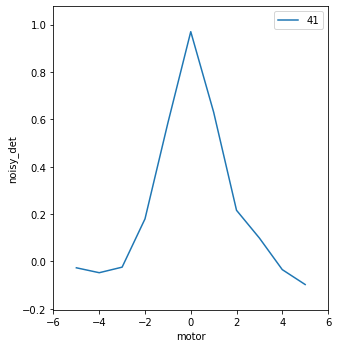

In [9]:
RE(bpp.pchain( mv(noisy_det.noise_multiplier, 0.1), scan([noisy_det], motor, -5, 5, 11) , mv(motor, 0) ) )

### Nice and Not So Nice Aspects of bpp.pchain 


<details><summary><b>Nice</b></summary>
    
- simple to assemble
    
- use `Cntl R` terninal search to re-use
    
- good way to test plans
</details>

<details><summary><b>Not So Nice</b></summary>
    
- hard to read
    
- even harder to manage multiple
    
</details>

### Custom plan defintions

Let make a custom plan to perform the last RE call.  We do this by making a python function.

But, what did we just do?  **Don't scroll up.**

In [10]:
%history

pip install -e gm_user
%run -i gm_user/user_profile.py
from gm_user import user_profile
%run -i gm_user/user_startup.py  user_startup_afternoon.py
# dir(ophyd.sim)
# from ophyd.sim import motor3 as temperature
RE.md['purpose']
RE(mv(motor, 0, temperature, 40))
#bpp.pchain?
RE(bpp.pchain( mv(noisy_det.noise_multiplier, 0.1), scan([noisy_det], motor, -5, 5, 11) , mv(motor, 0) ) )
%history


In [11]:
%history -n 6-22

   6: RE.md['purpose']
   7: RE(mv(motor, 0, temperature, 40))
   8: #bpp.pchain?
   9: RE(bpp.pchain( mv(noisy_det.noise_multiplier, 0.1), scan([noisy_det], motor, -5, 5, 11) , mv(motor, 0) ) )
  10: %history
  11: %history -n 6-22


From the above, we can easily create a simple plan that will take **FULL** advantage of bluesky

In [12]:
def align_peak():
    yield from scan([noisy_det], motor, -5, 5, 11) 
    yield from mv(motor, 0)



Transient Scan ID: 44     Time: 2023-04-21 11:53:56
Persistent Unique Scan ID: 'a6eebfb2-9c09-456e-85a7-aaaa59786937'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |  noisy_det |
+-----------+------------+------------+------------+
|         1 | 11:53:56.9 |     -5.000 |      0.075 |
|         2 | 11:53:57.0 |     -4.000 |     -0.011 |
|         3 | 11:53:57.0 |     -3.000 |      0.065 |
|         4 | 11:53:57.0 |     -2.000 |      0.182 |
|         5 | 11:53:57.1 |     -1.000 |      0.516 |
|         6 | 11:53:57.1 |      0.000 |      0.958 |
|         7 | 11:53:57.2 |      1.000 |      0.632 |
|         8 | 11:53:57.2 |      2.000 |      0.220 |
|         9 | 11:53:57.2 |      3.000 |      0.072 |
|        10 | 11:53:57.3 |      4.000 |      0.047 |
|        11 | 11:53:57.3 |      5.000 |     -0.014 |
+-----------+------------+------------+------------+
generator scan ['a6eebfb2'] (scan num: 44)





('a6eebfb2-9c09-456e-85a7-aaaa59786937',)

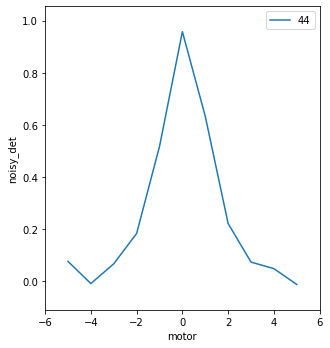

In [23]:
RE(align_peak())

## The problem in a real experiment

The peak will move as a function of temperature. In the next cells, we will:

1. Simulate our plan **before** using the RE.
2. Create a more robust plan for the specific experiment.

<div class="alert alert-block alert-info">
<b>Bluesky Feature:</b> There are two essential functions to inspect plans before calling them with the RE.
</div>


### Simulate

It's easy.  Just replace `RE` with `summarize_plan`.

In [14]:
summarize_plan(align_peak())

=================================== Open Run ===================================
motor -> -5.0
  Read ['noisy_det', 'motor']
motor -> -4.0
  Read ['noisy_det', 'motor']
motor -> -3.0
  Read ['noisy_det', 'motor']
motor -> -2.0
  Read ['noisy_det', 'motor']
motor -> -1.0
  Read ['noisy_det', 'motor']
motor -> 0.0
  Read ['noisy_det', 'motor']
motor -> 1.0
  Read ['noisy_det', 'motor']
motor -> 2.0
  Read ['noisy_det', 'motor']
motor -> 3.0
  Read ['noisy_det', 'motor']
motor -> 4.0
  Read ['noisy_det', 'motor']
motor -> 5.0
  Read ['noisy_det', 'motor']
================================== Close Run ===================================
motor -> 0


`summarize_plan` is more for syntax checking and object verification.  It does not check if the plan is actually feasilble.

### Check limits

To do this, replace `summarize_plan` with `check_limits`

In [15]:
check_limits(align_peak())

No errors and a returned prompt are a great sign!

## Motor position on peak maximum

Bluesky has a built in feature called `bec.peaks` (best effort callbacks).

Try `bec.peaks` and see what it is.  What python data structure does this resemble?

In [16]:
bec.peaks

{
'com':
    {'noisy_det': -0.26534488673887324}
,
'cen':
    {'noisy_det': -0.013119016721183874}
,
'max':
    {'noisy_det': (0.0,
                   1.044427916911302)}
,
'min':
    {'noisy_det': (3.0,
                   -0.07376593508917823)}
,
'fwhm':
    {'noisy_det': 2.1624557161817117}
,
}

Try to exact `motor` position at the scan's maximum value for `noisy_det`:




<details><summary><b>Copy Paste Solution</b></summary>

    
```python

print(bec.peaks["max"]["noisy_det"][0])

RE(mv(motor, bec.peaks["max"]["noisy_det"][0]) )


```
</details>


Let's finish our function

In [17]:
def align_peak():
    yield from scan([noisy_det], motor, -5, 5, 11) 
    yield from bps.sleep(3) #sometimes need this on actual hardware
    my_max = bec.peaks["max"]["noisy_det"][0]
    yield from mv(motor, my_max)

In [18]:
summarize_plan(align_peak())

=================================== Open Run ===================================
motor -> -5.0
  Read ['noisy_det', 'motor']
motor -> -4.0
  Read ['noisy_det', 'motor']
motor -> -3.0
  Read ['noisy_det', 'motor']
motor -> -2.0
  Read ['noisy_det', 'motor']
motor -> -1.0
  Read ['noisy_det', 'motor']
motor -> 0.0
  Read ['noisy_det', 'motor']
motor -> 1.0
  Read ['noisy_det', 'motor']
motor -> 2.0
  Read ['noisy_det', 'motor']
motor -> 3.0
  Read ['noisy_det', 'motor']
motor -> 4.0
  Read ['noisy_det', 'motor']
motor -> 5.0
  Read ['noisy_det', 'motor']
================================== Close Run ===================================
motor -> 0.0


### Assemble a super plan for our experiment
OUr experiment's design is to:
1. align a peak at a given temperature
2. count for some extended time (better statisics)
3. change temperature and repeat Items 1 and 2



Transient Scan ID: 43     Time: 2023-04-21 11:46:43
Persistent Unique Scan ID: 'b9a22071-42df-4a5a-a904-c553ecefb98e'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |  noisy_det |
+-----------+------------+------------+
|         1 | 11:46:43.7 |      1.048 |
|         2 | 11:46:43.8 |      0.983 |
|         3 | 11:46:43.8 |      1.014 |
|         4 | 11:46:43.9 |      0.934 |
|         5 | 11:46:43.9 |      1.081 |
|         6 | 11:46:44.0 |      0.945 |
|         7 | 11:46:44.0 |      0.908 |
|         8 | 11:46:44.1 |      1.027 |
|         9 | 11:46:44.1 |      0.906 |
|        10 | 11:46:44.2 |      1.047 |
+-----------+------------+------------+
generator count ['b9a22071'] (scan num: 43)





('b9a22071-42df-4a5a-a904-c553ecefb98e',)

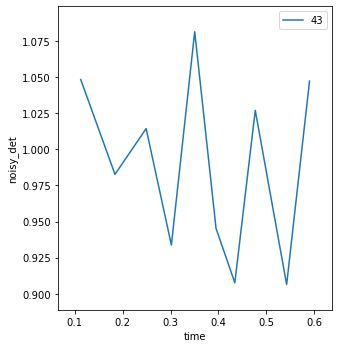

In [19]:
RE(count([noisy_det], num = 10))

In [24]:
def one_temperature():
    yield from align_peak()
    yield from count([noisy_det], 5)

Let's make sure this is correct by using `summarize_plan`.

Note:  we don't expect it to work.  Can you figure out what is wrong?  

<details><summary><b>Hint #1</b></summary>

If the traceback isn't all that useful.  Which function `align_peak()` or `count()` has sets a python variable?

</details>

<details><summary><b>Hint #2</b></summary>

Type `bec.peaks` after `RE(count([noisy_det], 5))`

```python
RE(count([noisy_det], 5))
bec.peaks

```

</details>


In [25]:
summarize_plan(one_temperature())

=================================== Open Run ===================================
motor -> -5.0
  Read ['noisy_det', 'motor']
motor -> -4.0
  Read ['noisy_det', 'motor']
motor -> -3.0
  Read ['noisy_det', 'motor']
motor -> -2.0
  Read ['noisy_det', 'motor']
motor -> -1.0
  Read ['noisy_det', 'motor']
motor -> 0.0
  Read ['noisy_det', 'motor']
motor -> 1.0
  Read ['noisy_det', 'motor']
motor -> 2.0
  Read ['noisy_det', 'motor']
motor -> 3.0
  Read ['noisy_det', 'motor']
motor -> 4.0
  Read ['noisy_det', 'motor']
motor -> 5.0
  Read ['noisy_det', 'motor']
================================== Close Run ===================================
motor -> 0.0
=================================== Open Run ===================================
  Read ['noisy_det']
  Read ['noisy_det']
  Read ['noisy_det']
  Read ['noisy_det']
  Read ['noisy_det']
================================== Close Run ===================================


## The cause of this failed `summarize_plan`

<details><summary><b>Solution</b></summary>

Performing a scan with a different detector before hand
    
```python
RE(scan([det], motor, -.5, .5, 3) )
summarize_plan(one_temperature)
   
   
```


</details>

<div class="alert alert-block alert-warning">
<b>Caution:</b> Some beamlines have put effort into high level plans.
    
    
* Not all beamline specific plans are compatible with the bluesky.simulation module.
    
* Others have more automated alignment plans and those should be used as per the staff instructions.
</div>


## Robust use of `bec.peaks`

<div class="alert alert-block alert-info">
<b>Tip:</b> Don't be shy about adding print() inside functions to help with debugging.
</div>


In [ ]:
def align_peak():
    uid = yield from scan([noisy_det], motor, -5, 5, 11) 
    if uid is not None:
        #print('doing')
        yield from bps.sleep(3) #sometimes need this on actual hardware
        my_max = bec.peaks["max"]["noisy_det"][0]
        yield from mv(motor, my_max)
    #else:
        #print('passing')
        #pass

In [ ]:
RE(scan([noisy_det], motor, -5, 5, 11) )

In [ ]:
summarize_plan(one_temperature())

# Start Josh

### We have the major data collection plan

Let's iterate over some temperatures.

In [ ]:
for myT in [43, 45, 47, 50, 51, 52, 53, 54]:
    print(myT)

<div class="alert alert-block alert-info">
<b>Tip:</b> Easier ways to do this'
    
    - range()
    - "list comprehension"
</div>


## Create and test our overnight script
Try to modify the function below.

<details><summary><b>Solution</b></summary>

This represents my ideal solution.  There are variations of this that are also acceptable.

Copy and Paste the below in one cell to see the difference
    
```python
def my_experiment(myT_list):
    for myT in myT_list:
        print(f'Changing temperature to {myT}')
        yield from mv(temperature, myT)
        yield from one_temperature()
        print(f'\tFinished scans for temperature {myT}')

summarize_plan(my_experiment([31,]))
check_limits(my_experiment([31,]))
```


</details>

In [ ]:
## FIX THE FUNCTION
def my_experiment():
    yield from mv(temperature, ?)
    yield from one_temperature()

In [ ]:
summarize_plan(my_experiment())

In [ ]:
check_limits(my_experiment())

## Questions

## What's next



* [Good Night Bluesky](./Good%20Night%20Bluesky.ipynb)